In [ ]:
# 環境設定
!pip install pandas sklearn
!pip install pystan
!pip install statsmodels
!pip install fbprophet

In [476]:
# 定数

# 予測区間
PREDICTION_INTERVAL=0.90
PREDICTION_LABEL="{}% prediction interval".format(PREDICTION_INTERVAL*100)

In [14]:
import pandas as pd

df = pd.read_csv("nikkei_stock_average_daily_jp.csv", index_col=0, parse_dates=[0])
df.head()

,closing_price,starting_price,high_price,low_price
date,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


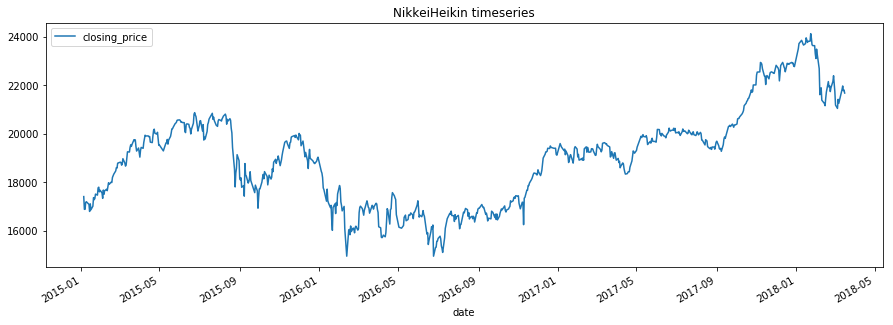

In [359]:
df[['closing_price']].plot(figsize=(15, 5), title="NikkeiHeikin timeseries")

In [168]:
import numpy as np
import random
random.seed(0)

LENGTH_OF_SEQUENCE = 50

"""
create sequence x, y data
"""
def load_data(data, maxlen, feature_x=['closing_price'], predict_y='closing_price'):
    features = data[feature_x]
    predict_col = data.columns.get_loc(predict_y)
    X = []
    Y = []
    for i in range(features.shape[0]-maxlen-1):
        X.append(features.iloc[i:i+maxlen].as_matrix())
        Y.append(np.array([data.iloc[i+maxlen, predict_col]]))
    return np.array(X), np.array(Y)

(trainX, trainY) = load_data(df, LENGTH_OF_SEQUENCE)

In [182]:
from keras.initializers import Constant
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers.normalization import BatchNormalization

IN_OUT_NEURONS = 1
HIDDEN_NEURONS = 200

def create_model(length_of_sequence=LENGTH_OF_SEQUENCE, hidden_neurons=HIDDEN_NEURONS,
                 in_out_neurons=IN_OUT_NEURONS, constant=None):
    if constant is None:
        constant = 'zeros'
    else:
        constant = Constant(constant)
        
    model = Sequential()
    model.add(LSTM(hidden_neurons, 
              batch_input_shape=(None, length_of_sequence, in_out_neurons),
              return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dense(IN_OUT_NEURONS, bias_initializer=constant))
    model.add(Activation("linear"))

    model.compile(loss="mape", optimizer="adam")
    
    return model

In [173]:
model = create_model(20000)

In [174]:
hist = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.05)

Train on 698 samples, validate on 37 samples
Epoch 1/100
698/698 [==============================] - 11s 16ms/step - loss: 9.5022 - val_loss: 9.6272
Epoch 2/100
698/698 [==============================] - 4s 5ms/step - loss: 9.5004 - val_loss: 9.6306
Epoch 3/100
698/698 [==============================] - 5s 7ms/step - loss: 9.4978 - val_loss: 9.6356
Epoch 4/100
698/698 [==============================] - 4s 6ms/step - loss: 9.4940 - val_loss: 9.6425
Epoch 5/100
698/698 [==============================] - 4s 6ms/step - loss: 9.4890 - val_loss: 9.6516
Epoch 6/100
698/698 [==============================] - 5s 7ms/step - loss: 9.4826 - val_loss: 9.6627
Epoch 7/100
698/698 [==============================] - 5s 7ms/step - loss: 9.4750 - val_loss: 9.6756
Epoch 8/100
698/698 [==============================] - 4s 6ms/step - loss: 9.4661 - val_loss: 9.6912
Epoch 9/100
698/698 [==============================] - 5s 7ms/step - loss: 9.4560 - val_loss: 9.7089
Epoch 10/100
698/698 [======================

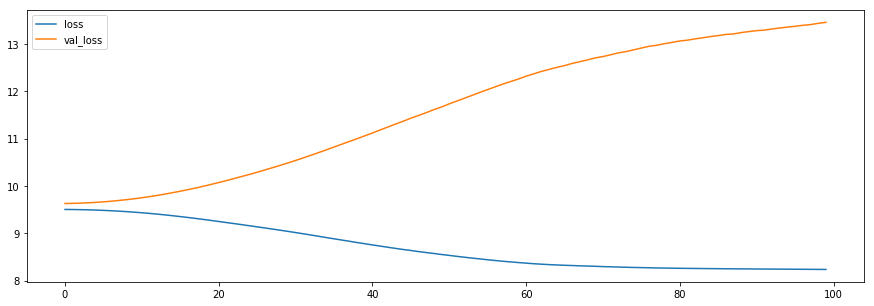

In [175]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(figsize=(15, 5))

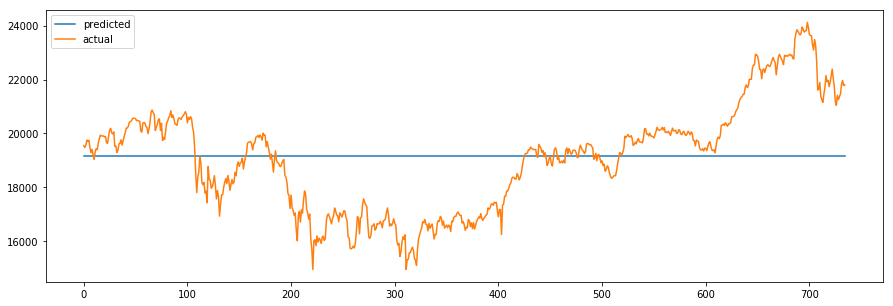

In [176]:
predicted = model.predict(trainX[:1000])
test_df = pd.DataFrame(predicted[:], columns=["predicted"])
test_df["actual"] = trainY[:1000]
test_df.plot(figsize=(15, 5))

In [214]:
from sklearn.preprocessing import StandardScaler

NORM_COL = 'closing_price_norm'
n = 50

scaler = StandardScaler()
df[NORM_COL] = scaler.fit_transform(df[['closing_price']])

(trainXdash, trainYdash) = load_data(df, n, [NORM_COL], NORM_COL)
modeldash = create_model(length_of_sequence=n)
histdash = modeldash.fit(trainXdash, trainYdash, batch_size=32, epochs=100, validation_split=0.05)

Train on 698 samples, validate on 37 samples
Epoch 1/100
160/698 [=====>........................] - ETA: 2:35 - loss: 188.1755

/home/ksgwr/venv/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257144). Check your callbacks.
  % delta_t_median)


698/698 [==============================] - 50s 72ms/step - loss: 117.1092 - val_loss: 31.2437
Epoch 2/100
698/698 [==============================] - 4s 6ms/step - loss: 100.1859 - val_loss: 18.6171
Epoch 3/100
698/698 [==============================] - 4s 5ms/step - loss: 80.2685 - val_loss: 11.8753
Epoch 4/100
698/698 [==============================] - 4s 5ms/step - loss: 78.5607 - val_loss: 24.3884
Epoch 5/100
698/698 [==============================] - 4s 5ms/step - loss: 86.4204 - val_loss: 71.9414
Epoch 6/100
698/698 [==============================] - 4s 5ms/step - loss: 93.9192 - val_loss: 41.8233
Epoch 7/100
698/698 [==============================] - 4s 5ms/step - loss: 93.7216 - val_loss: 16.1175
Epoch 8/100
698/698 [==============================] - 4s 5ms/step - loss: 73.0994 - val_loss: 69.9524
Epoch 9/100
698/698 [==============================] - 4s 5ms/step - loss: 80.9026 - val_loss: 92.7694
Epoch 10/100
698/698 [==============================] - 4s 5ms/step - loss: 65.79

Epoch 80/100
698/698 [==============================] - 4s 5ms/step - loss: 66.9282 - val_loss: 47.0830
Epoch 81/100
698/698 [==============================] - 4s 5ms/step - loss: 62.8225 - val_loss: 19.6269
Epoch 82/100
698/698 [==============================] - 4s 5ms/step - loss: 80.6833 - val_loss: 82.3140
Epoch 83/100
698/698 [==============================] - 4s 5ms/step - loss: 69.9945 - val_loss: 13.9788
Epoch 84/100
698/698 [==============================] - 4s 5ms/step - loss: 77.6706 - val_loss: 47.4629
Epoch 85/100
698/698 [==============================] - 4s 5ms/step - loss: 86.2940 - val_loss: 79.7369
Epoch 86/100
698/698 [==============================] - 4s 5ms/step - loss: 71.3102 - val_loss: 50.9742
Epoch 87/100
698/698 [==============================] - 3s 5ms/step - loss: 69.7100 - val_loss: 13.0036
Epoch 88/100
698/698 [==============================] - 3s 5ms/step - loss: 74.6092 - val_loss: 26.7728
Epoch 89/100
698/698 [==============================] - 4s 5ms/s

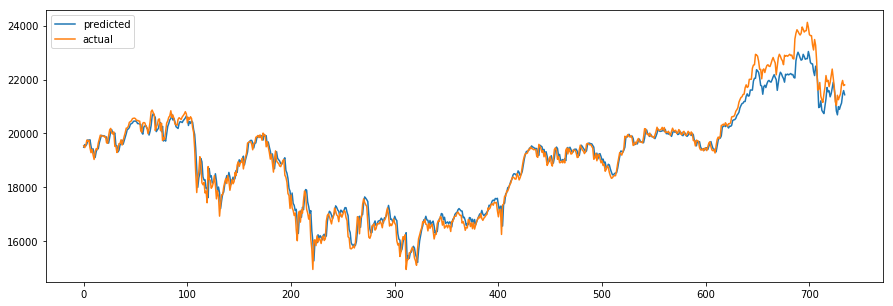

In [218]:
predicted_dash = scaler.inverse_transform(modeldash.predict(trainXdash[:1000]))
test_dash_df = pd.DataFrame(predicted_dash[:], columns=["predicted"])
test_dash_df["actual"] = trainY[:1000]
test_dash_df.plot(figsize=(15, 5))

# 平均値から外れるほど精度が下がる, nが大きくなるほど一応精度は上がる

[ 0.0047114   0.05674172 -0.05733919  0.0048359  -0.09199214  0.15840361
 -0.04152701  0.04415858 -0.07163177 -0.0542192   0.09854171 -0.08523525
  0.03284509  0.04245511 -0.06238112  0.015296    0.00921059  0.02355073
  0.0088833  -0.01997026 -0.07382632  0.08441344 -0.0338428  -0.00930246
  0.03886849  0.03291678 -0.1137721   0.01347748  0.09660951 -0.06282735
 -0.02531078  0.04755512 -0.07706822  0.00743122  0.05683344 -0.02409874
  0.06771014 -0.00381421  0.01850378 -0.07554627 -0.01053932  0.04023728
 -0.01233715  0.0208606  -0.01046685 -0.00182863  0.05090404 -0.0508379
  0.00640212  0.98353536]


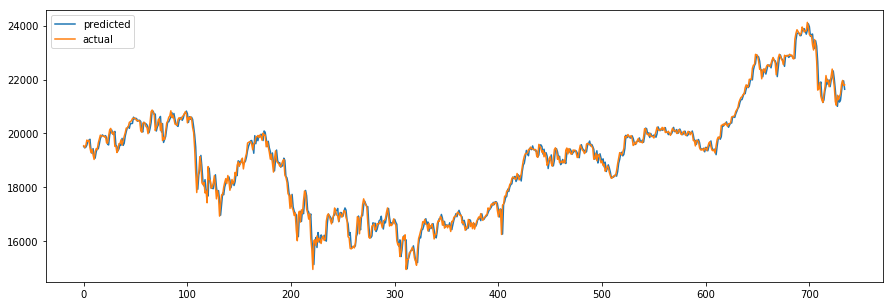

In [249]:
#重回帰分析
from sklearn import linear_model
clf = linear_model.LinearRegression()
 
trainX_2d = trainX.reshape(len(trainX),50)
trainY_1d = trainY.reshape(len(trainY))

clf.fit(trainX_2d, trainY_1d)

# 重要度分析
print(clf.coef_)

predicted_linear = clf.predict(trainX_2d[:1000])

test_linear_df = pd.DataFrame(predicted_linear[:], columns=["predicted"])
test_linear_df["actual"] = trainY_1d[:1000]
test_linear_df.plot(figsize=(15, 5))

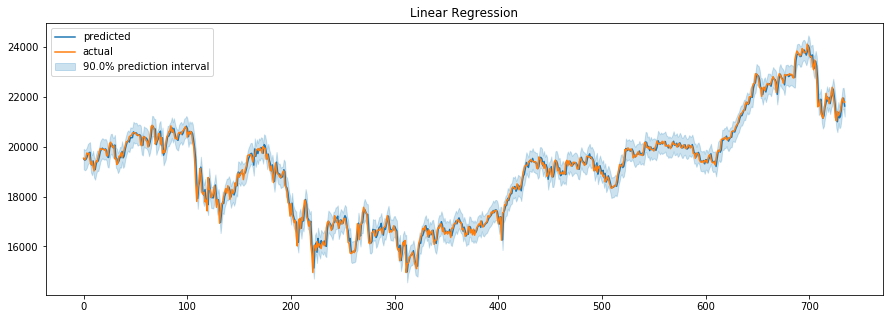

In [480]:
# 重回帰
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt

#linear_clf = sm.OLS(df["closing_price"], sm.add_constant(df[["starting_price"]])).fit()
linear_clf = sm.OLS(trainY_1d, sm.add_constant(trainX_2d)).fit()

prstd, iv_l, iv_u = wls_prediction_std(linear_clf, alpha=1-PREDICTION_INTERVAL)

plt.figure(figsize=(15, 5))
plt.plot(range(len(trainY_1d)), linear_clf.fittedvalues, label="predicted")
plt.fill_between(range(len(trainY_1d)), iv_l, iv_u,
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(range(len(trainY_1d)), trainY_1d, label="actual")
plt.title("Linear Regression")
plt.legend()
plt.show()

In [473]:
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     980.0
Date:                Sun, 25 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:48:24   Log-Likelihood:                -5049.9
No. Observations:                 735   AIC:                         1.020e+04
Df Residuals:                     684   BIC:                         1.044e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.9817    100.148      0.779      0.436    -118.652     274.616
x1             0.0047      0.040      0.118      0.906      -0.073       0.083
x2             0.0567      0.055      1.041      0.298      -0.050       0.164
x3            -0.0573      0.054     -1.052      0.293      -0.164       0.050
x4             0.0048      0.055      0.089      0.929      -0.102       0.112
x5            -0.0920      0.054     -1.689      0.092      -0.199       0.015
x6             0.1584      0.054      2.927      0.004       0.052       0.265
x7            -0.0415      0.054     -0.767      0.443      -0.148       0.065
x8             0.0442      0.054      0.815      0.415      -0.062       0.151
x9            -0.0716      0.054     -1.322      0.187      -0.178       0.035
x10           -0.0542      0.054     -1.001      0.317      -0.161       0.052
x11            0.0985      0.054      1.823      0.069      -0.008       0.205
x12           -0.0852      0.054     -1.573      0.116      -0.192       0.021
x13            0.0328      0.054      0.606      0.544      -0.073       0.139
x14            0.0425      0.054      0.784      0.433      -0.064       0.149
x15           -0.0624      0.054     -1.153      0.249      -0.169       0.044
x16            0.0153      0.054      0.282      0.778      -0.091       0.122
x17            0.0092      0.054      0.170      0.865      -0.097       0.116
x18            0.0236      0.054      0.435      0.664      -0.083       0.130
x19            0.0089      0.054      0.164      0.870      -0.098       0.115
x20           -0.0200      0.054     -0.368      0.713      -0.127       0.087
x21           -0.0738      0.054     -1.363      0.173      -0.180       0.032
x22            0.0844      0.054      1.560      0.119      -0.022       0.191
x23           -0.0338      0.054     -0.624      0.533      -0.140       0.073
x24           -0.0093      0.054     -0.172      0.864      -0.116       0.097
x25            0.0389      0.054      0.721      0.471      -0.067       0.145
x26            0.0329      0.054      0.611      0.542      -0.073       0.139
x27           -0.1138      0.054     -2.124      0.034      -0.219      -0.009
x28            0.0135      0.054      0.252      0.801      -0.092       0.119
x29            0.0966      0.053      1.806      0.071      -0.008       0.202
x30           -0.0628      0.053     -1.175      0.241      -0.168       0.042
x31           -0.0253      0.054     -0.473      0.637      -0.130       0.080
x32            0.0476      0.053      0.889      0.374      -0.057       0.153
x33           -0.0771      0.053     -1.447      0.148      -0.182       0.028
x34            0.0074      0.053      0.140      0.889      -0.097       0.112
x35            0.0568      0.053      1.069      0.286      -0.048       0.161
x3

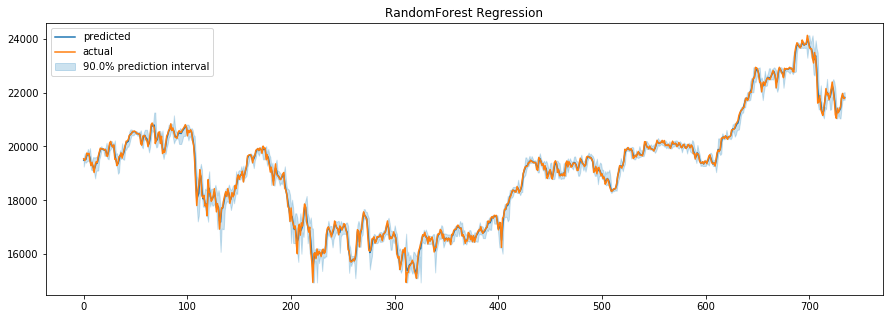

In [481]:
# RandomForest Regression
from sklearn.ensemble import RandomForestRegressor
r_forest = RandomForestRegressor(
            n_estimators=100,
            criterion='mse',
            random_state=1,
            n_jobs=-1
)

r_forest.fit(trainX_2d, trainY_1d)

predicted_rf = r_forest.predict(trainX_2d[:1000])

# http://blog.datadive.net/prediction-intervals-for-random-forests/
def pred_ints(model, X, prediction_interval):
    alpha = 100 - prediction_interval * 100
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict([X[x]])[0])
        err_down.append(np.percentile(preds, alpha / 2. ))
        err_up.append(np.percentile(preds, 100 - alpha / 2.))
    return err_down, err_up

iv_l, iv_u = pred_ints(r_forest, trainX_2d, prediction_interval=PREDICTION_INTERVAL)

plt.figure(figsize=(15, 5))
plt.plot(range(len(trainY_1d)), predicted_rf, label="predicted")
plt.fill_between(range(len(trainY_1d)), iv_l, iv_u,
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(range(len(trainY_1d)), trainY_1d, label="actual")
plt.legend()
plt.title("RandomForest Regression")
plt.show()

/home/ksgwr/venv/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ksgwr/venv/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/ksgwr/venv/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/ksgwr/venv/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available

(1, 0)
(1, 0)


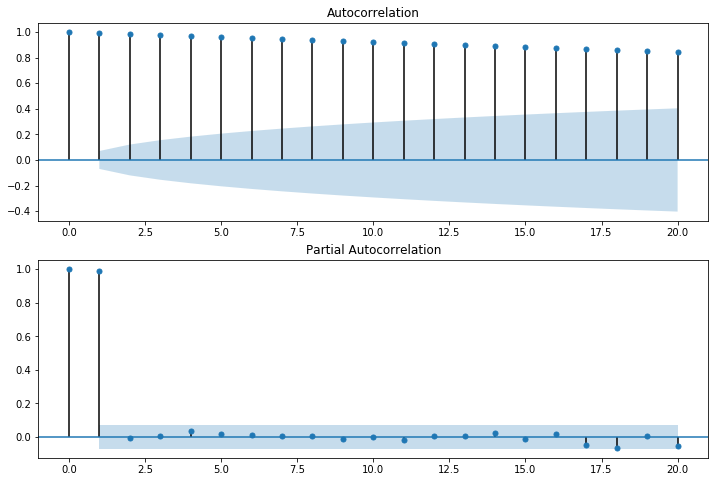

In [345]:
# ARMAのパラメータ分析
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['closing_price'].values, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['closing_price'].values, lags=20, ax=ax2)
fig.show()

info_criteria = sm.tsa.stattools.arma_order_select_ic(
                    df['closing_price'].values, ic=['aic', 'bic']
                )
print(info_criteria.aic_min_order)
print(info_criteria.bic_min_order)

arma aic: 10847.04259899386
arma mse: 60628.89076221891


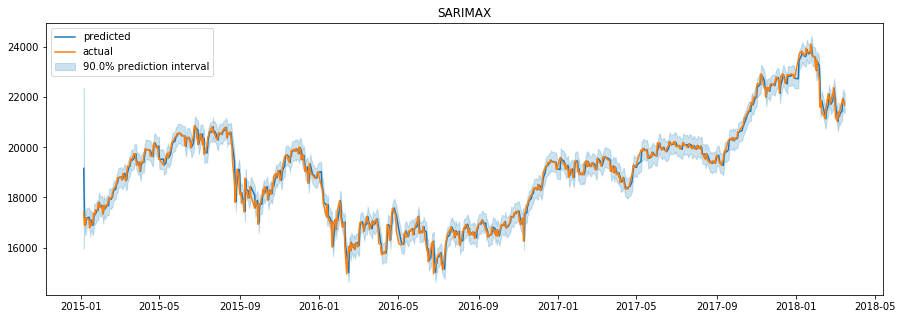

In [483]:
# SARIMAX
import matplotlib.pyplot as plt
from pandas.core import datetools
import statsmodels.api as sm

# 自己回帰パラメータ(AR)
p = 1
# 差分の階数(I)
d = 0
# 移動平均パラメータ(MA)
q = 1
sarimax=sm.tsa.SARIMAX(df[['closing_price']], trend='c', order = [p,d,q]).fit()
print("arma aic:",sarimax.aic)
print("arma mse: {}".format(np.array([r ** 2 for r in sarimax.resid]).mean()))

predicted_sarimax = sarimax.get_prediction(start=df.first_valid_index(),end=df.last_valid_index())
conf_sarimax = predicted_sarimax.conf_int(alpha=1-PREDICTION_INTERVAL)

plt.figure(figsize=(15, 5))
plt.plot(df.index, predicted_sarimax.predicted_mean, label="predicted")
plt.fill_between(df.index, conf_sarimax['lower closing_price'], conf_sarimax['upper closing_price'],
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(df.index, df['closing_price'].values, label="actual")
plt.legend()
plt.title("SARIMAX")
plt.show()

p = 1 ~ 20
q = 0 or 1

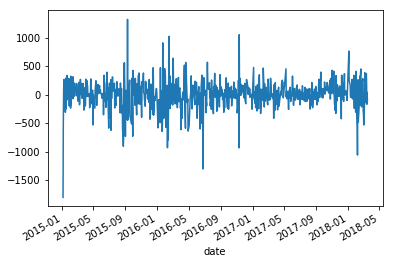

In [348]:
arma.resid.plot()

In [439]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          closing_price   No. Observations:                  786
Model:                     ARMA(1, 1)   Log Likelihood               -5419.517
Method:                       css-mle   S.D. of innovations            238.273
Date:                Sat, 24 Mar 2018   AIC                          10847.033
Time:                        21:19:51   BIC                          10865.701
Sample:                    01-05-2015   HQIC                         10854.211
                         - 03-16-2018                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.921e+04   1040.199     18.470      0.000    1.72e+04    2.13e+04
ar.L1.closing_price     0.9931      0.004    251.080      0.000       0.985       1.001
ma.L1.closing_price    -0.0208      0.037     -0.569      0.569      -0.092       0.051
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0069           +0.0000j            1.0069            0.0000
MA.1           48.1150           +0.0000j           48.1150            0.0000
-----------------------------------------------------------------------------
"""

In [484]:
from fbprophet import Prophet

df['y'] = df['closing_price']
df['ds'] = df.index
prophet = Prophet(interval_width=PREDICTION_INTERVAL)
prophet.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ksgwr/venv/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


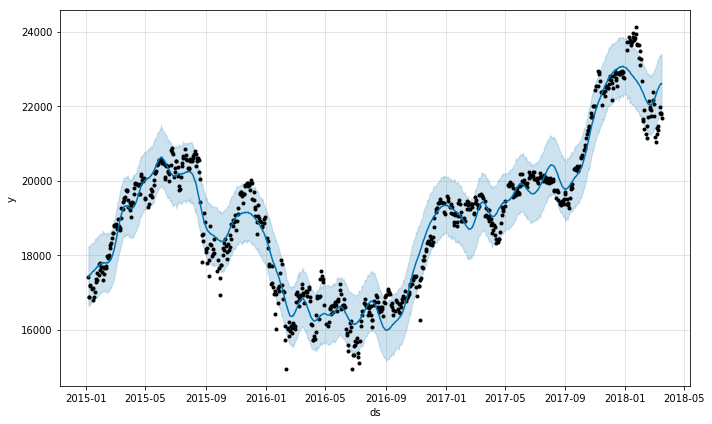

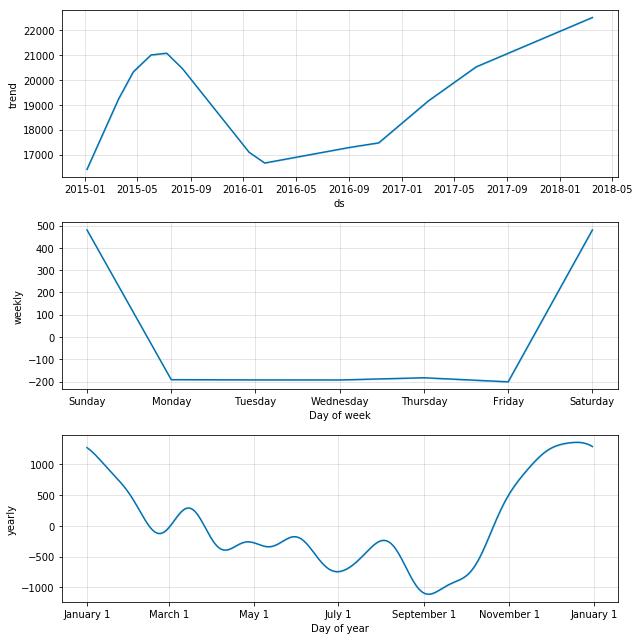

In [485]:
predicted_prophet = prophet.predict(df)
prophet.plot(predicted_prophet)
prophet.plot_components(predicted_prophet);

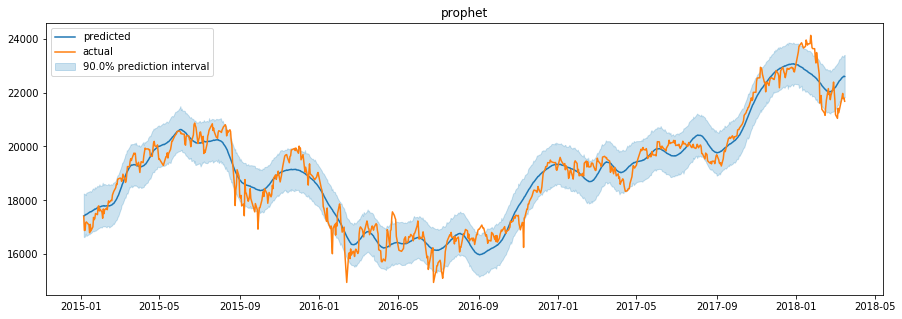

In [486]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, predicted_prophet['yhat'].values, label="predicted")
plt.fill_between(df.index, predicted_prophet['yhat_lower'], predicted_prophet['yhat_upper'],
                 color='#0072B2', alpha=0.2, label=PREDICTION_LABEL)
plt.plot(df.index, df['closing_price'].values, label="actual")
plt.legend()
plt.title("prophet")
plt.show()

In [254]:
# https://pythondatascience.plavox.info/scikit-learn/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0
# https://qiita.com/TomokIshii/items/b3ebe2b60c5d3d5a0d5a
# https://qiita.com/yossyyossy/items/ac6961ca5a0e765f56be
# https://github.com/facebook/prophet

TODO: prophetとARMAで予測
    未来予測の評価まで行う
    信頼区間もプロットする